# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [6]:
from tqdm import tqdm

### 训练器

In [7]:
def regressor_trainer(skmodel,
                      data_dict,
                      window_size=10,
                      epoch=1000,
                      eval_step=10,
                    on_test_log=False):
    mae_lst,rmse_lst = [], []
    for i in tqdm(range(epoch)):
        if i%eval_step==0 and on_test_log:
            print('---------------------------------------------------')
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            real_train_y = train_y[:,-1]
            
            test_x = train_data.copy()
        
            # (batch, window_size)-->(batch, 1)
            skmodel.fit(train_x,real_train_y)
    
            # Eval on every eval_step
            if (i+1)%eval_step==0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    online_x = np.reshape(np.array(test_x[-window_size:]), (-1, window_size)).astype(np.float32)
            
                    next_point = skmodel.predict(online_x)[0]
                    
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                
                mae, rmse = evaluation(y_test=test_data, y_predict=point_list)

                mae_lst.append(mae)
                rmse_lst.append(rmse)

                if on_test_log:
                    print(f'Epoch:{i} {name} MAE:{mae:.4f} | RMSE:{rmse:<6.4f}')
    print(f'Model:{skmodel.__str__()}')
    print(f'MAE:{np.average(mae_lst):.4f} RMSE:{np.average(rmse_lst):.4f}')
    return skmodel

### 预测绘图

### 绘图函数

In [8]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 CNN

一维CNN，滑动窗口，在采样后的数据上做。

后续可考虑多层stack。

In [9]:
from typing import List,Dict,Tuple

In [10]:
from collections import OrderedDict

In [11]:
import torch

In [12]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [13]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [14]:
class CNNSingleModel(BaseModel):

    def __init__(self,
                 kernel_size:int,
                 stride:int,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(CNNSingleModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        if kernel_size>self.prefix_length:
            assert(f'Error kernel_size:{kernel_size} must less than prefix_length:{self.prefix_length}')
        
        self.CNNLayer = torch.nn.Conv1d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=kernel_size,
                                        stride=stride)
        
        self.OutputLinear = torch.nn.Linear(in_features=int((self.prefix_length-kernel_size+1)/stride),
                                            out_features=1,
                                            bias=False)
        self.__post_init__()
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = self.CNNLayer(x)
        y = self.OutputLinear(x)
        return y.reshape((y.shape[0],1))

In [15]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-4    # learning rate
weight_decay = 0.0
kernel_size = 16
stride = 1
batch_size = 512

In [16]:
eval_step = 1000

In [17]:
data_dict = bmap

In [18]:
model = CNNSingleModel(kernel_size=kernel_size,
                       stride=stride,
                 prefix_length=window_size)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [20]:
on_test_log = True

In [21]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [23]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|                                                                                | 0/1000000 [00:00<?, ?it/s]

---------------------------------------------------


  0%|                                                                     | 6/1000000 [00:01<42:43:02,  6.50it/s]

Epoch:0 Loss:2.7707 MAE:1.5002 | RMSE:1.5279


  0%|                                                                   | 1001/1000000 [00:22<7:10:55, 38.64it/s]

---------------------------------------------------
Epoch:1000 Loss:0.5035 MAE:0.7890 | RMSE:0.8060


  0%|▏                                                                  | 2003/1000000 [00:44<7:18:23, 37.94it/s]

---------------------------------------------------
Epoch:2000 Loss:0.2526 MAE:0.5508 | RMSE:0.5643


  0%|▏                                                                  | 3005/1000000 [01:06<6:49:02, 40.62it/s]

---------------------------------------------------
Epoch:3000 Loss:0.1689 MAE:0.4294 | RMSE:0.4414


  0%|▎                                                                  | 4004/1000000 [01:29<7:49:28, 35.36it/s]

---------------------------------------------------
Epoch:4000 Loss:0.1269 MAE:0.3548 | RMSE:0.3657


  1%|▎                                                                  | 5002/1000000 [01:51<7:31:31, 36.73it/s]

---------------------------------------------------
Epoch:5000 Loss:0.1017 MAE:0.3041 | RMSE:0.3143


  1%|▍                                                                  | 6003/1000000 [02:15<7:34:56, 36.41it/s]

---------------------------------------------------
Epoch:6000 Loss:0.0848 MAE:0.2675 | RMSE:0.2773


  1%|▍                                                                  | 7004/1000000 [02:40<7:42:17, 35.80it/s]

---------------------------------------------------
Epoch:7000 Loss:0.0728 MAE:0.2400 | RMSE:0.2495


  1%|▌                                                                  | 8001/1000000 [03:04<7:54:54, 34.81it/s]

---------------------------------------------------
Epoch:8000 Loss:0.0638 MAE:0.2187 | RMSE:0.2280


  1%|▌                                                                  | 9002/1000000 [03:28<7:50:02, 35.14it/s]

---------------------------------------------------
Epoch:9000 Loss:0.0567 MAE:0.2017 | RMSE:0.2107


  1%|▋                                                                 | 10003/1000000 [03:53<8:06:20, 33.93it/s]

---------------------------------------------------
Epoch:10000 Loss:0.0511 MAE:0.1878 | RMSE:0.1966


  1%|▋                                                                 | 11000/1000000 [04:16<6:14:03, 44.07it/s]

---------------------------------------------------
Epoch:11000 Loss:0.0465 MAE:0.1762 | RMSE:0.1849


  1%|▊                                                                 | 12002/1000000 [04:42<7:38:17, 35.93it/s]

---------------------------------------------------
Epoch:12000 Loss:0.0426 MAE:0.1664 | RMSE:0.1750


  1%|▊                                                                 | 13000/1000000 [05:05<6:00:01, 45.69it/s]

---------------------------------------------------
Epoch:13000 Loss:0.0394 MAE:0.1580 | RMSE:0.1664


  1%|▉                                                                 | 14004/1000000 [05:28<7:38:29, 35.84it/s]

---------------------------------------------------
Epoch:14000 Loss:0.0366 MAE:0.1507 | RMSE:0.1591


  2%|▉                                                                 | 15004/1000000 [05:51<7:15:58, 37.65it/s]

---------------------------------------------------
Epoch:15000 Loss:0.0342 MAE:0.1443 | RMSE:0.1526


  2%|█                                                                 | 16004/1000000 [06:14<7:27:11, 36.67it/s]

---------------------------------------------------
Epoch:16000 Loss:0.0321 MAE:0.1387 | RMSE:0.1469


  2%|█                                                                 | 17003/1000000 [06:37<7:54:27, 34.53it/s]

---------------------------------------------------
Epoch:17000 Loss:0.0302 MAE:0.1337 | RMSE:0.1418


  2%|█▏                                                                | 18002/1000000 [07:00<7:13:44, 37.73it/s]

---------------------------------------------------
Epoch:18000 Loss:0.0285 MAE:0.1292 | RMSE:0.1373


  2%|█▎                                                                | 19002/1000000 [07:22<7:44:52, 35.17it/s]

---------------------------------------------------
Epoch:19000 Loss:0.0270 MAE:0.1252 | RMSE:0.1332


  2%|█▎                                                                | 20004/1000000 [07:45<7:49:31, 34.79it/s]

---------------------------------------------------
Epoch:20000 Loss:0.0257 MAE:0.1216 | RMSE:0.1295


  2%|█▍                                                                | 21004/1000000 [08:08<7:29:55, 36.27it/s]

---------------------------------------------------
Epoch:21000 Loss:0.0245 MAE:0.1183 | RMSE:0.1262


  2%|█▍                                                                | 22003/1000000 [08:30<7:32:10, 36.05it/s]

---------------------------------------------------
Epoch:22000 Loss:0.0234 MAE:0.1153 | RMSE:0.1231


  2%|█▌                                                                | 23004/1000000 [08:53<7:24:29, 36.63it/s]

---------------------------------------------------
Epoch:23000 Loss:0.0224 MAE:0.1125 | RMSE:0.1203


  2%|█▌                                                                | 24002/1000000 [09:16<7:42:01, 35.21it/s]

---------------------------------------------------
Epoch:24000 Loss:0.0215 MAE:0.1100 | RMSE:0.1177


  3%|█▋                                                                | 25005/1000000 [09:39<7:14:07, 37.43it/s]

---------------------------------------------------
Epoch:25000 Loss:0.0206 MAE:0.1076 | RMSE:0.1154


  3%|█▋                                                                | 26002/1000000 [10:02<7:48:44, 34.63it/s]

---------------------------------------------------
Epoch:26000 Loss:0.0198 MAE:0.1055 | RMSE:0.1131


  3%|█▊                                                                | 27005/1000000 [10:24<7:05:22, 38.12it/s]

---------------------------------------------------
Epoch:27000 Loss:0.0191 MAE:0.1035 | RMSE:0.1111


  3%|█▊                                                                | 28003/1000000 [10:47<7:24:25, 36.45it/s]

---------------------------------------------------
Epoch:28000 Loss:0.0184 MAE:0.1016 | RMSE:0.1092


  3%|█▉                                                                | 29000/1000000 [11:10<6:19:51, 42.60it/s]

---------------------------------------------------
Epoch:29000 Loss:0.0178 MAE:0.0998 | RMSE:0.1074


  3%|█▉                                                                | 30004/1000000 [11:32<6:57:44, 38.70it/s]

---------------------------------------------------
Epoch:30000 Loss:0.0172 MAE:0.0982 | RMSE:0.1057


  3%|██                                                                | 31003/1000000 [11:55<7:26:31, 36.17it/s]

---------------------------------------------------
Epoch:31000 Loss:0.0167 MAE:0.0967 | RMSE:0.1042


  3%|██                                                                | 32004/1000000 [12:18<7:35:38, 35.41it/s]

---------------------------------------------------
Epoch:32000 Loss:0.0162 MAE:0.0952 | RMSE:0.1027


  3%|██▏                                                               | 33004/1000000 [12:41<7:19:16, 36.69it/s]

---------------------------------------------------
Epoch:33000 Loss:0.0157 MAE:0.0939 | RMSE:0.1013


  3%|██▏                                                               | 34004/1000000 [13:03<7:26:47, 36.04it/s]

---------------------------------------------------
Epoch:34000 Loss:0.0152 MAE:0.0926 | RMSE:0.1000


  4%|██▎                                                               | 35001/1000000 [13:26<7:21:09, 36.46it/s]

---------------------------------------------------
Epoch:35000 Loss:0.0148 MAE:0.0914 | RMSE:0.0988


  4%|██▍                                                               | 36003/1000000 [13:49<7:16:54, 36.77it/s]

---------------------------------------------------
Epoch:36000 Loss:0.0144 MAE:0.0902 | RMSE:0.0976


  4%|██▍                                                               | 37005/1000000 [14:12<7:11:43, 37.18it/s]

---------------------------------------------------
Epoch:37000 Loss:0.0140 MAE:0.0891 | RMSE:0.0965


  4%|██▌                                                               | 38001/1000000 [14:34<7:52:22, 33.94it/s]

---------------------------------------------------
Epoch:38000 Loss:0.0137 MAE:0.0881 | RMSE:0.0955


  4%|██▌                                                               | 39001/1000000 [14:57<7:28:16, 35.73it/s]

---------------------------------------------------
Epoch:39000 Loss:0.0133 MAE:0.0871 | RMSE:0.0945


  4%|██▋                                                               | 40003/1000000 [15:20<7:54:59, 33.68it/s]

---------------------------------------------------
Epoch:40000 Loss:0.0130 MAE:0.0862 | RMSE:0.0935


  4%|██▋                                                               | 41000/1000000 [15:43<5:57:21, 44.73it/s]

---------------------------------------------------
Epoch:41000 Loss:0.0127 MAE:0.0853 | RMSE:0.0926


  4%|██▊                                                               | 42004/1000000 [16:06<6:57:47, 38.22it/s]

---------------------------------------------------
Epoch:42000 Loss:0.0124 MAE:0.0845 | RMSE:0.0918


  4%|██▊                                                               | 43002/1000000 [16:28<7:18:02, 36.41it/s]

---------------------------------------------------
Epoch:43000 Loss:0.0121 MAE:0.0836 | RMSE:0.0910


  4%|██▉                                                               | 44002/1000000 [16:51<7:25:48, 35.74it/s]

---------------------------------------------------
Epoch:44000 Loss:0.0118 MAE:0.0829 | RMSE:0.0902


  5%|██▉                                                               | 45002/1000000 [17:14<7:41:20, 34.50it/s]

---------------------------------------------------
Epoch:45000 Loss:0.0116 MAE:0.0821 | RMSE:0.0894


  5%|███                                                               | 46005/1000000 [17:37<7:26:59, 35.57it/s]

---------------------------------------------------
Epoch:46000 Loss:0.0113 MAE:0.0814 | RMSE:0.0887


  5%|███                                                               | 47002/1000000 [18:00<7:22:38, 35.88it/s]

---------------------------------------------------
Epoch:47000 Loss:0.0111 MAE:0.0807 | RMSE:0.0880


  5%|███▏                                                              | 48001/1000000 [18:22<7:52:46, 33.56it/s]

---------------------------------------------------
Epoch:48000 Loss:0.0109 MAE:0.0801 | RMSE:0.0873


  5%|███▏                                                              | 49004/1000000 [18:45<7:19:36, 36.05it/s]

---------------------------------------------------
Epoch:49000 Loss:0.0107 MAE:0.0795 | RMSE:0.0867


  5%|███▎                                                              | 50004/1000000 [19:08<7:04:10, 37.33it/s]

---------------------------------------------------
Epoch:50000 Loss:0.0105 MAE:0.0789 | RMSE:0.0861


  5%|███▎                                                              | 51003/1000000 [19:32<7:27:13, 35.37it/s]

---------------------------------------------------
Epoch:51000 Loss:0.0103 MAE:0.0783 | RMSE:0.0855


  5%|███▍                                                              | 52002/1000000 [19:55<7:55:46, 33.21it/s]

---------------------------------------------------
Epoch:52000 Loss:0.0101 MAE:0.0777 | RMSE:0.0849


  5%|███▍                                                              | 53005/1000000 [20:18<7:08:35, 36.83it/s]

---------------------------------------------------
Epoch:53000 Loss:0.0099 MAE:0.0772 | RMSE:0.0844


  5%|███▌                                                              | 54005/1000000 [20:41<7:09:47, 36.68it/s]

---------------------------------------------------
Epoch:54000 Loss:0.0097 MAE:0.0767 | RMSE:0.0839


  6%|███▋                                                              | 55001/1000000 [21:03<7:35:23, 34.59it/s]

---------------------------------------------------
Epoch:55000 Loss:0.0095 MAE:0.0762 | RMSE:0.0834


  6%|███▋                                                              | 56005/1000000 [21:26<7:13:56, 36.26it/s]

---------------------------------------------------
Epoch:56000 Loss:0.0094 MAE:0.0757 | RMSE:0.0829


  6%|███▊                                                              | 57001/1000000 [21:49<7:32:01, 34.77it/s]

---------------------------------------------------
Epoch:57000 Loss:0.0092 MAE:0.0752 | RMSE:0.0824


  6%|███▊                                                              | 58002/1000000 [22:12<7:30:34, 34.84it/s]

---------------------------------------------------
Epoch:58000 Loss:0.0090 MAE:0.0748 | RMSE:0.0819


  6%|███▉                                                              | 59002/1000000 [22:34<7:04:08, 36.98it/s]

---------------------------------------------------
Epoch:59000 Loss:0.0089 MAE:0.0743 | RMSE:0.0815


  6%|███▉                                                              | 60002/1000000 [22:57<7:12:03, 36.26it/s]

---------------------------------------------------
Epoch:60000 Loss:0.0088 MAE:0.0739 | RMSE:0.0811


  6%|████                                                              | 61002/1000000 [23:20<7:05:33, 36.78it/s]

---------------------------------------------------
Epoch:61000 Loss:0.0086 MAE:0.0735 | RMSE:0.0807


  6%|████                                                              | 61999/1000000 [23:43<6:13:10, 41.89it/s]

---------------------------------------------------
Epoch:62000 Loss:0.0085 MAE:0.0731 | RMSE:0.0803


  6%|████▏                                                             | 63001/1000000 [24:05<7:10:38, 36.26it/s]

---------------------------------------------------
Epoch:63000 Loss:0.0084 MAE:0.0727 | RMSE:0.0799


  6%|████▏                                                             | 64005/1000000 [24:28<7:31:33, 34.55it/s]

---------------------------------------------------
Epoch:64000 Loss:0.0082 MAE:0.0723 | RMSE:0.0795


  7%|████▎                                                             | 65003/1000000 [24:51<7:15:55, 35.75it/s]

---------------------------------------------------
Epoch:65000 Loss:0.0081 MAE:0.0720 | RMSE:0.0791


  7%|████▎                                                             | 66004/1000000 [25:14<7:10:28, 36.16it/s]

---------------------------------------------------
Epoch:66000 Loss:0.0080 MAE:0.0716 | RMSE:0.0788


  7%|████▍                                                             | 67001/1000000 [25:37<7:05:23, 36.56it/s]

---------------------------------------------------
Epoch:67000 Loss:0.0079 MAE:0.0713 | RMSE:0.0784


  7%|████▍                                                             | 68005/1000000 [26:00<7:28:45, 34.61it/s]

---------------------------------------------------
Epoch:68000 Loss:0.0078 MAE:0.0709 | RMSE:0.0781


  7%|████▌                                                             | 69003/1000000 [26:22<7:35:17, 34.08it/s]

---------------------------------------------------
Epoch:69000 Loss:0.0077 MAE:0.0706 | RMSE:0.0778


  7%|████▌                                                             | 70001/1000000 [26:45<7:04:23, 36.52it/s]

---------------------------------------------------
Epoch:70000 Loss:0.0075 MAE:0.0703 | RMSE:0.0774


  7%|████▋                                                             | 71002/1000000 [27:08<7:07:18, 36.23it/s]

---------------------------------------------------
Epoch:71000 Loss:0.0074 MAE:0.0700 | RMSE:0.0771


  7%|████▊                                                             | 72002/1000000 [27:31<7:14:29, 35.60it/s]

---------------------------------------------------
Epoch:72000 Loss:0.0073 MAE:0.0697 | RMSE:0.0768


  7%|████▊                                                             | 73002/1000000 [27:54<7:13:39, 35.63it/s]

---------------------------------------------------
Epoch:73000 Loss:0.0072 MAE:0.0694 | RMSE:0.0765


  7%|████▉                                                             | 74003/1000000 [28:16<6:51:58, 37.46it/s]

---------------------------------------------------
Epoch:74000 Loss:0.0072 MAE:0.0691 | RMSE:0.0762


  8%|████▉                                                             | 75004/1000000 [28:40<7:35:51, 33.82it/s]

---------------------------------------------------
Epoch:75000 Loss:0.0071 MAE:0.0688 | RMSE:0.0760


  8%|█████                                                             | 76002/1000000 [29:03<6:43:22, 38.18it/s]

---------------------------------------------------
Epoch:76000 Loss:0.0070 MAE:0.0686 | RMSE:0.0757


  8%|█████                                                             | 77005/1000000 [29:26<6:51:06, 37.42it/s]

---------------------------------------------------
Epoch:77000 Loss:0.0069 MAE:0.0683 | RMSE:0.0754


  8%|█████▏                                                            | 78001/1000000 [29:48<7:13:44, 35.43it/s]

---------------------------------------------------
Epoch:78000 Loss:0.0068 MAE:0.0681 | RMSE:0.0752


  8%|█████▏                                                            | 79001/1000000 [30:11<7:29:15, 34.17it/s]

---------------------------------------------------
Epoch:79000 Loss:0.0067 MAE:0.0678 | RMSE:0.0749


  8%|█████▎                                                            | 80003/1000000 [30:34<6:46:40, 37.70it/s]

---------------------------------------------------
Epoch:80000 Loss:0.0066 MAE:0.0676 | RMSE:0.0747


  8%|█████▎                                                            | 81003/1000000 [30:58<7:13:33, 35.33it/s]

---------------------------------------------------
Epoch:81000 Loss:0.0066 MAE:0.0673 | RMSE:0.0744


  8%|█████▍                                                            | 82003/1000000 [31:22<7:32:47, 33.79it/s]

---------------------------------------------------
Epoch:82000 Loss:0.0065 MAE:0.0671 | RMSE:0.0742


  8%|█████▍                                                            | 83005/1000000 [31:45<7:01:15, 36.28it/s]

---------------------------------------------------
Epoch:83000 Loss:0.0064 MAE:0.0669 | RMSE:0.0740


  8%|█████▌                                                            | 84001/1000000 [32:09<7:00:56, 36.27it/s]

---------------------------------------------------
Epoch:84000 Loss:0.0063 MAE:0.0666 | RMSE:0.0738


  9%|█████▌                                                            | 85002/1000000 [32:32<7:10:15, 35.44it/s]

---------------------------------------------------
Epoch:85000 Loss:0.0063 MAE:0.0664 | RMSE:0.0735


  9%|█████▋                                                            | 86000/1000000 [32:55<5:34:36, 45.53it/s]

---------------------------------------------------
Epoch:86000 Loss:0.0062 MAE:0.0662 | RMSE:0.0733


  9%|█████▋                                                            | 87002/1000000 [33:18<6:57:56, 36.41it/s]

---------------------------------------------------
Epoch:87000 Loss:0.0061 MAE:0.0660 | RMSE:0.0731


  9%|█████▊                                                            | 88003/1000000 [33:41<7:34:24, 33.45it/s]

---------------------------------------------------
Epoch:88000 Loss:0.0061 MAE:0.0658 | RMSE:0.0729


  9%|█████▊                                                            | 88999/1000000 [34:03<5:43:56, 44.15it/s]

---------------------------------------------------
Epoch:89000 Loss:0.0060 MAE:0.0656 | RMSE:0.0727


  9%|█████▉                                                            | 90003/1000000 [34:27<7:29:51, 33.71it/s]

---------------------------------------------------
Epoch:90000 Loss:0.0059 MAE:0.0654 | RMSE:0.0725


  9%|██████                                                            | 91001/1000000 [34:50<7:06:00, 35.56it/s]

---------------------------------------------------
Epoch:91000 Loss:0.0059 MAE:0.0652 | RMSE:0.0723


  9%|██████                                                            | 92005/1000000 [35:14<6:57:47, 36.22it/s]

---------------------------------------------------
Epoch:92000 Loss:0.0058 MAE:0.0650 | RMSE:0.0721


  9%|██████▏                                                           | 93000/1000000 [35:36<5:48:20, 43.40it/s]

---------------------------------------------------
Epoch:93000 Loss:0.0057 MAE:0.0649 | RMSE:0.0719


  9%|██████▏                                                           | 94001/1000000 [36:00<7:33:51, 33.27it/s]

---------------------------------------------------
Epoch:94000 Loss:0.0057 MAE:0.0647 | RMSE:0.0718


 10%|██████▎                                                           | 95004/1000000 [36:23<7:27:48, 33.68it/s]

---------------------------------------------------
Epoch:95000 Loss:0.0056 MAE:0.0645 | RMSE:0.0716


 10%|██████▎                                                           | 96000/1000000 [36:45<5:33:45, 45.14it/s]

---------------------------------------------------
Epoch:96000 Loss:0.0056 MAE:0.0643 | RMSE:0.0714


 10%|██████▍                                                           | 97002/1000000 [37:09<7:45:02, 32.36it/s]

---------------------------------------------------
Epoch:97000 Loss:0.0055 MAE:0.0642 | RMSE:0.0712


 10%|██████▍                                                           | 98003/1000000 [37:32<7:21:10, 34.08it/s]

---------------------------------------------------
Epoch:98000 Loss:0.0055 MAE:0.0640 | RMSE:0.0711


 10%|██████▌                                                           | 99003/1000000 [37:55<6:54:40, 36.21it/s]

---------------------------------------------------
Epoch:99000 Loss:0.0054 MAE:0.0638 | RMSE:0.0709


 10%|██████▌                                                          | 100001/1000000 [38:17<7:12:27, 34.68it/s]

---------------------------------------------------
Epoch:100000 Loss:0.0054 MAE:0.0637 | RMSE:0.0707


 10%|██████▌                                                          | 101004/1000000 [38:40<7:14:02, 34.52it/s]

---------------------------------------------------
Epoch:101000 Loss:0.0053 MAE:0.0635 | RMSE:0.0706


 10%|██████▋                                                          | 102004/1000000 [39:04<7:05:10, 35.20it/s]

---------------------------------------------------
Epoch:102000 Loss:0.0053 MAE:0.0634 | RMSE:0.0704


 10%|██████▋                                                          | 103004/1000000 [39:27<7:04:00, 35.26it/s]

---------------------------------------------------
Epoch:103000 Loss:0.0052 MAE:0.0632 | RMSE:0.0703


 10%|██████▊                                                          | 104000/1000000 [39:49<5:40:12, 43.90it/s]

---------------------------------------------------
Epoch:104000 Loss:0.0052 MAE:0.0631 | RMSE:0.0701


 11%|██████▊                                                          | 105003/1000000 [40:13<7:25:35, 33.48it/s]

---------------------------------------------------
Epoch:105000 Loss:0.0051 MAE:0.0629 | RMSE:0.0700


 11%|██████▉                                                          | 106003/1000000 [40:36<6:51:35, 36.20it/s]

---------------------------------------------------
Epoch:106000 Loss:0.0051 MAE:0.0628 | RMSE:0.0698


 11%|██████▉                                                          | 107001/1000000 [40:59<7:11:43, 34.47it/s]

---------------------------------------------------
Epoch:107000 Loss:0.0050 MAE:0.0626 | RMSE:0.0697


 11%|███████                                                          | 108002/1000000 [41:22<6:55:22, 35.79it/s]

---------------------------------------------------
Epoch:108000 Loss:0.0050 MAE:0.0625 | RMSE:0.0696


 11%|███████                                                          | 108999/1000000 [41:45<5:19:37, 46.46it/s]

---------------------------------------------------
Epoch:109000 Loss:0.0049 MAE:0.0623 | RMSE:0.0694


 11%|███████▏                                                         | 110002/1000000 [42:08<7:01:44, 35.17it/s]

---------------------------------------------------
Epoch:110000 Loss:0.0049 MAE:0.0622 | RMSE:0.0693


 11%|███████▏                                                         | 111003/1000000 [42:32<7:16:34, 33.94it/s]

---------------------------------------------------
Epoch:111000 Loss:0.0049 MAE:0.0621 | RMSE:0.0691


 11%|███████▎                                                         | 112003/1000000 [42:56<7:20:17, 33.61it/s]

---------------------------------------------------
Epoch:112000 Loss:0.0048 MAE:0.0619 | RMSE:0.0690


 11%|███████▎                                                         | 112999/1000000 [43:19<6:03:25, 40.68it/s]

---------------------------------------------------
Epoch:113000 Loss:0.0048 MAE:0.0618 | RMSE:0.0689


 11%|███████▍                                                         | 114000/1000000 [43:46<5:38:36, 43.61it/s]

---------------------------------------------------
Epoch:114000 Loss:0.0047 MAE:0.0617 | RMSE:0.0688


 12%|███████▍                                                         | 115005/1000000 [44:10<7:02:20, 34.92it/s]

---------------------------------------------------
Epoch:115000 Loss:0.0047 MAE:0.0616 | RMSE:0.0686


 12%|███████▌                                                         | 116001/1000000 [44:36<8:09:15, 30.11it/s]

---------------------------------------------------
Epoch:116000 Loss:0.0047 MAE:0.0614 | RMSE:0.0685


 12%|███████▌                                                         | 117002/1000000 [45:01<6:51:28, 35.76it/s]

---------------------------------------------------
Epoch:117000 Loss:0.0046 MAE:0.0613 | RMSE:0.0684


 12%|███████▋                                                         | 118003/1000000 [45:26<7:29:49, 32.68it/s]

---------------------------------------------------
Epoch:118000 Loss:0.0046 MAE:0.0612 | RMSE:0.0683


 12%|███████▋                                                         | 119001/1000000 [45:51<7:20:20, 33.35it/s]

---------------------------------------------------
Epoch:119000 Loss:0.0046 MAE:0.0611 | RMSE:0.0681


 12%|███████▊                                                         | 120001/1000000 [46:15<7:06:06, 34.42it/s]

---------------------------------------------------
Epoch:120000 Loss:0.0045 MAE:0.0610 | RMSE:0.0680


 12%|███████▊                                                         | 121005/1000000 [46:39<6:43:36, 36.30it/s]

---------------------------------------------------
Epoch:121000 Loss:0.0045 MAE:0.0609 | RMSE:0.0679


 12%|███████▉                                                         | 122004/1000000 [47:03<6:39:41, 36.61it/s]

---------------------------------------------------
Epoch:122000 Loss:0.0044 MAE:0.0607 | RMSE:0.0678


 12%|███████▉                                                         | 123001/1000000 [47:27<8:12:35, 29.67it/s]

---------------------------------------------------
Epoch:123000 Loss:0.0044 MAE:0.0606 | RMSE:0.0677


 12%|████████                                                         | 123999/1000000 [47:53<6:58:38, 34.88it/s]

---------------------------------------------------
Epoch:124000 Loss:0.0044 MAE:0.0605 | RMSE:0.0676


 12%|████████▏                                                        | 125000/1000000 [48:19<6:03:59, 40.06it/s]

---------------------------------------------------
Epoch:125000 Loss:0.0043 MAE:0.0604 | RMSE:0.0675


 13%|████████▏                                                        | 126000/1000000 [48:45<5:37:33, 43.15it/s]

---------------------------------------------------
Epoch:126000 Loss:0.0043 MAE:0.0603 | RMSE:0.0674


 13%|████████▎                                                        | 126999/1000000 [49:09<5:33:29, 43.63it/s]

---------------------------------------------------
Epoch:127000 Loss:0.0043 MAE:0.0602 | RMSE:0.0673


 13%|████████▎                                                        | 128003/1000000 [49:34<7:28:08, 32.43it/s]

---------------------------------------------------
Epoch:128000 Loss:0.0043 MAE:0.0601 | RMSE:0.0671


 13%|████████▍                                                        | 128999/1000000 [49:58<5:52:07, 41.23it/s]

---------------------------------------------------
Epoch:129000 Loss:0.0042 MAE:0.0600 | RMSE:0.0670


 13%|████████▍                                                        | 129999/1000000 [50:24<6:06:17, 39.59it/s]

---------------------------------------------------
Epoch:130000 Loss:0.0042 MAE:0.0599 | RMSE:0.0669


 13%|████████▌                                                        | 131004/1000000 [50:49<7:08:32, 33.80it/s]

---------------------------------------------------
Epoch:131000 Loss:0.0042 MAE:0.0598 | RMSE:0.0668


 13%|████████▌                                                        | 132003/1000000 [51:14<7:53:43, 30.54it/s]

---------------------------------------------------
Epoch:132000 Loss:0.0041 MAE:0.0597 | RMSE:0.0667


 13%|████████▋                                                        | 133003/1000000 [51:38<7:23:16, 32.60it/s]

---------------------------------------------------
Epoch:133000 Loss:0.0041 MAE:0.0596 | RMSE:0.0666


 13%|████████▋                                                        | 134001/1000000 [52:06<7:58:16, 30.18it/s]

---------------------------------------------------
Epoch:134000 Loss:0.0041 MAE:0.0595 | RMSE:0.0665


 14%|████████▊                                                        | 135003/1000000 [52:30<7:22:08, 32.61it/s]

---------------------------------------------------
Epoch:135000 Loss:0.0040 MAE:0.0594 | RMSE:0.0665


 14%|████████▊                                                        | 136000/1000000 [52:54<5:15:49, 45.60it/s]

---------------------------------------------------
Epoch:136000 Loss:0.0040 MAE:0.0593 | RMSE:0.0664


 14%|████████▉                                                        | 137002/1000000 [53:20<7:42:55, 31.07it/s]

---------------------------------------------------
Epoch:137000 Loss:0.0040 MAE:0.0592 | RMSE:0.0663


 14%|████████▉                                                        | 137999/1000000 [53:45<6:23:08, 37.50it/s]

---------------------------------------------------
Epoch:138000 Loss:0.0040 MAE:0.0591 | RMSE:0.0662


 14%|█████████                                                        | 139002/1000000 [54:10<8:38:14, 27.69it/s]

---------------------------------------------------
Epoch:139000 Loss:0.0039 MAE:0.0590 | RMSE:0.0661


 14%|█████████                                                        | 140001/1000000 [54:36<7:52:50, 30.31it/s]

---------------------------------------------------
Epoch:140000 Loss:0.0039 MAE:0.0589 | RMSE:0.0660


 14%|█████████▏                                                       | 141000/1000000 [55:00<5:40:56, 41.99it/s]

---------------------------------------------------
Epoch:141000 Loss:0.0039 MAE:0.0588 | RMSE:0.0659


 14%|█████████▏                                                       | 142002/1000000 [55:24<7:01:52, 33.90it/s]

---------------------------------------------------
Epoch:142000 Loss:0.0039 MAE:0.0588 | RMSE:0.0658


 14%|█████████▎                                                       | 143003/1000000 [55:47<7:59:17, 29.80it/s]

---------------------------------------------------
Epoch:143000 Loss:0.0038 MAE:0.0587 | RMSE:0.0657


 14%|█████████▎                                                       | 144001/1000000 [56:15<7:57:11, 29.90it/s]

---------------------------------------------------
Epoch:144000 Loss:0.0038 MAE:0.0586 | RMSE:0.0656


 15%|█████████▍                                                       | 145002/1000000 [56:47<9:29:44, 25.01it/s]

---------------------------------------------------
Epoch:145000 Loss:0.0038 MAE:0.0585 | RMSE:0.0656


 15%|█████████▍                                                       | 146000/1000000 [57:23<9:24:30, 25.21it/s]

---------------------------------------------------
Epoch:146000 Loss:0.0038 MAE:0.0584 | RMSE:0.0655


 15%|█████████▌                                                       | 146998/1000000 [58:03<9:05:43, 26.05it/s]

---------------------------------------------------


 15%|█████████▍                                                      | 147004/1000000 [58:03<12:36:15, 18.80it/s]

Epoch:147000 Loss:0.0037 MAE:0.0583 | RMSE:0.0654


 15%|█████████▍                                                      | 148000/1000000 [58:50<14:06:09, 16.78it/s]

---------------------------------------------------


 15%|█████████▍                                                      | 148004/1000000 [58:51<19:52:25, 11.91it/s]

Epoch:148000 Loss:0.0037 MAE:0.0583 | RMSE:0.0653


 15%|█████████▌                                                      | 148999/1000000 [59:39<11:51:25, 19.94it/s]

---------------------------------------------------


 15%|█████████▌                                                      | 149003/1000000 [59:39<17:51:28, 13.24it/s]

Epoch:149000 Loss:0.0037 MAE:0.0582 | RMSE:0.0652


 15%|█████████▎                                                    | 149999/1000000 [1:00:31<12:58:15, 18.20it/s]

---------------------------------------------------


 15%|█████████▎                                                    | 150003/1000000 [1:00:32<19:34:55, 12.06it/s]

Epoch:150000 Loss:0.0037 MAE:0.0581 | RMSE:0.0652


 15%|█████████▎                                                    | 150999/1000000 [1:01:30<13:37:42, 17.30it/s]

---------------------------------------------------


 15%|█████████▎                                                    | 151003/1000000 [1:01:31<19:31:31, 12.08it/s]

Epoch:151000 Loss:0.0036 MAE:0.0580 | RMSE:0.0651


 15%|█████████▍                                                    | 151999/1000000 [1:02:31<12:53:35, 18.27it/s]

---------------------------------------------------


 15%|█████████▍                                                    | 152003/1000000 [1:02:31<19:28:47, 12.09it/s]

Epoch:152000 Loss:0.0036 MAE:0.0579 | RMSE:0.0650


 15%|█████████▍                                                    | 152999/1000000 [1:03:31<14:35:39, 16.12it/s]

---------------------------------------------------


 15%|█████████▍                                                    | 153003/1000000 [1:03:32<22:04:36, 10.66it/s]

Epoch:153000 Loss:0.0036 MAE:0.0579 | RMSE:0.0649


 15%|█████████▌                                                    | 153999/1000000 [1:04:34<13:09:21, 17.86it/s]

---------------------------------------------------


 15%|█████████▌                                                    | 154003/1000000 [1:04:34<19:19:56, 12.16it/s]

Epoch:154000 Loss:0.0036 MAE:0.0578 | RMSE:0.0648


 15%|█████████▌                                                    | 154999/1000000 [1:05:33<14:06:24, 16.64it/s]

---------------------------------------------------


 16%|█████████▌                                                    | 155003/1000000 [1:05:33<20:05:04, 11.69it/s]

Epoch:155000 Loss:0.0036 MAE:0.0577 | RMSE:0.0648


 16%|█████████▋                                                    | 155999/1000000 [1:06:32<13:43:47, 17.08it/s]

---------------------------------------------------


 16%|█████████▋                                                    | 156003/1000000 [1:06:33<20:49:56, 11.25it/s]

Epoch:156000 Loss:0.0035 MAE:0.0576 | RMSE:0.0647


 16%|█████████▋                                                    | 157000/1000000 [1:07:34<13:11:11, 17.76it/s]

---------------------------------------------------


 16%|█████████▋                                                    | 157004/1000000 [1:07:34<19:05:06, 12.27it/s]

Epoch:157000 Loss:0.0035 MAE:0.0576 | RMSE:0.0646


 16%|█████████▊                                                    | 158000/1000000 [1:08:33<14:04:56, 16.61it/s]

---------------------------------------------------


 16%|█████████▊                                                    | 158004/1000000 [1:08:33<21:01:03, 11.13it/s]

Epoch:158000 Loss:0.0035 MAE:0.0575 | RMSE:0.0646


 16%|█████████▊                                                    | 159000/1000000 [1:09:33<14:25:54, 16.19it/s]

---------------------------------------------------


 16%|█████████▊                                                    | 159004/1000000 [1:09:33<21:00:09, 11.12it/s]

Epoch:159000 Loss:0.0035 MAE:0.0574 | RMSE:0.0645


 16%|█████████▉                                                    | 159999/1000000 [1:10:32<12:59:06, 17.97it/s]

---------------------------------------------------


 16%|█████████▉                                                    | 160003/1000000 [1:10:32<19:29:02, 11.98it/s]

Epoch:160000 Loss:0.0035 MAE:0.0573 | RMSE:0.0644


 16%|█████████▉                                                    | 160999/1000000 [1:11:33<13:49:37, 16.86it/s]

---------------------------------------------------


 16%|█████████▉                                                    | 161003/1000000 [1:11:33<20:51:34, 11.17it/s]

Epoch:161000 Loss:0.0034 MAE:0.0573 | RMSE:0.0643


 16%|██████████                                                    | 161999/1000000 [1:12:33<14:26:23, 16.12it/s]

---------------------------------------------------


 16%|██████████                                                    | 162003/1000000 [1:12:33<21:15:17, 10.95it/s]

Epoch:162000 Loss:0.0034 MAE:0.0572 | RMSE:0.0643


 16%|██████████                                                    | 162999/1000000 [1:13:33<17:03:59, 13.62it/s]

---------------------------------------------------


 16%|██████████                                                    | 163003/1000000 [1:13:34<29:08:05,  7.98it/s]

Epoch:163000 Loss:0.0034 MAE:0.0571 | RMSE:0.0642


 16%|██████████▏                                                   | 163999/1000000 [1:14:33<15:50:32, 14.66it/s]

---------------------------------------------------


 16%|██████████▏                                                   | 164003/1000000 [1:14:34<21:41:36, 10.70it/s]

Epoch:164000 Loss:0.0034 MAE:0.0571 | RMSE:0.0641


 16%|██████████▏                                                   | 165000/1000000 [1:15:32<14:00:35, 16.56it/s]

---------------------------------------------------


 17%|██████████▏                                                   | 165004/1000000 [1:15:33<20:52:27, 11.11it/s]

Epoch:165000 Loss:0.0034 MAE:0.0570 | RMSE:0.0641


 17%|██████████▎                                                   | 165999/1000000 [1:16:32<13:02:26, 17.77it/s]

---------------------------------------------------


 17%|██████████▎                                                   | 166003/1000000 [1:16:32<19:06:21, 12.13it/s]

Epoch:166000 Loss:0.0033 MAE:0.0569 | RMSE:0.0640


 17%|██████████▎                                                   | 166999/1000000 [1:17:31<13:11:19, 17.54it/s]

---------------------------------------------------


 17%|██████████▎                                                   | 167003/1000000 [1:17:32<20:01:18, 11.56it/s]

Epoch:167000 Loss:0.0033 MAE:0.0569 | RMSE:0.0639


 17%|██████████▍                                                   | 168000/1000000 [1:18:31<13:07:15, 17.61it/s]

---------------------------------------------------


 17%|██████████▍                                                   | 168004/1000000 [1:18:32<18:57:08, 12.19it/s]

Epoch:168000 Loss:0.0033 MAE:0.0568 | RMSE:0.0639


 17%|██████████▍                                                   | 169000/1000000 [1:19:33<13:44:02, 16.81it/s]

---------------------------------------------------


 17%|██████████▍                                                   | 169004/1000000 [1:19:33<20:26:58, 11.29it/s]

Epoch:169000 Loss:0.0033 MAE:0.0567 | RMSE:0.0638


 17%|██████████▌                                                   | 169999/1000000 [1:20:32<12:30:36, 18.43it/s]

---------------------------------------------------


 17%|██████████▌                                                   | 170003/1000000 [1:20:33<19:23:11, 11.89it/s]

Epoch:170000 Loss:0.0033 MAE:0.0567 | RMSE:0.0638


 17%|██████████▌                                                   | 170999/1000000 [1:21:31<13:33:59, 16.97it/s]

---------------------------------------------------


 17%|██████████▌                                                   | 171003/1000000 [1:21:32<19:44:15, 11.67it/s]

Epoch:171000 Loss:0.0033 MAE:0.0566 | RMSE:0.0637


 17%|██████████▋                                                   | 171999/1000000 [1:22:32<13:13:08, 17.40it/s]

---------------------------------------------------


 17%|██████████▋                                                   | 172003/1000000 [1:22:32<19:47:21, 11.62it/s]

Epoch:172000 Loss:0.0032 MAE:0.0566 | RMSE:0.0636


 17%|██████████▋                                                   | 172999/1000000 [1:23:32<13:24:31, 17.13it/s]

---------------------------------------------------


 17%|██████████▋                                                   | 173005/1000000 [1:23:33<16:58:48, 13.53it/s]

Epoch:173000 Loss:0.0032 MAE:0.0565 | RMSE:0.0636


 17%|██████████▊                                                   | 173999/1000000 [1:24:33<13:05:02, 17.54it/s]

---------------------------------------------------


 17%|██████████▊                                                   | 174003/1000000 [1:24:33<18:55:23, 12.13it/s]

Epoch:174000 Loss:0.0032 MAE:0.0564 | RMSE:0.0635


 18%|██████████▊                                                   | 175000/1000000 [1:25:32<13:22:04, 17.14it/s]

---------------------------------------------------


 18%|██████████▊                                                   | 175004/1000000 [1:25:32<19:52:48, 11.53it/s]

Epoch:175000 Loss:0.0032 MAE:0.0564 | RMSE:0.0634


 18%|██████████▉                                                   | 176000/1000000 [1:26:32<13:31:53, 16.92it/s]

---------------------------------------------------


 18%|██████████▉                                                   | 176004/1000000 [1:26:33<19:39:45, 11.64it/s]

Epoch:176000 Loss:0.0032 MAE:0.0563 | RMSE:0.0634


 18%|██████████▉                                                   | 177000/1000000 [1:27:32<13:33:41, 16.86it/s]

---------------------------------------------------


 18%|██████████▉                                                   | 177004/1000000 [1:27:33<19:51:44, 11.51it/s]

Epoch:177000 Loss:0.0032 MAE:0.0563 | RMSE:0.0633


 18%|███████████                                                   | 177999/1000000 [1:28:35<15:03:40, 15.16it/s]

---------------------------------------------------


 18%|███████████                                                   | 178003/1000000 [1:28:36<22:46:31, 10.03it/s]

Epoch:178000 Loss:0.0031 MAE:0.0562 | RMSE:0.0633


 18%|███████████                                                   | 178999/1000000 [1:29:41<14:11:13, 16.07it/s]

---------------------------------------------------


 18%|███████████                                                   | 179003/1000000 [1:29:42<20:19:36, 11.22it/s]

Epoch:179000 Loss:0.0031 MAE:0.0561 | RMSE:0.0632


 18%|███████████▏                                                  | 179999/1000000 [1:30:40<13:44:04, 16.58it/s]

---------------------------------------------------


 18%|███████████▏                                                  | 180003/1000000 [1:30:41<20:21:22, 11.19it/s]

Epoch:180000 Loss:0.0031 MAE:0.0561 | RMSE:0.0632


 18%|███████████▏                                                  | 180999/1000000 [1:31:44<15:12:14, 14.96it/s]

---------------------------------------------------


 18%|███████████▏                                                  | 181003/1000000 [1:31:45<20:19:41, 11.19it/s]

Epoch:181000 Loss:0.0031 MAE:0.0560 | RMSE:0.0631


 18%|███████████▎                                                  | 181999/1000000 [1:32:47<13:15:57, 17.13it/s]

---------------------------------------------------


 18%|███████████▎                                                  | 182003/1000000 [1:32:47<19:02:45, 11.93it/s]

Epoch:182000 Loss:0.0031 MAE:0.0560 | RMSE:0.0630


 18%|███████████▎                                                  | 183000/1000000 [1:33:47<13:01:53, 17.42it/s]

---------------------------------------------------


 18%|███████████▎                                                  | 183004/1000000 [1:33:47<19:09:12, 11.85it/s]

Epoch:183000 Loss:0.0031 MAE:0.0559 | RMSE:0.0630


 18%|███████████▍                                                  | 184000/1000000 [1:34:52<13:36:02, 16.67it/s]

---------------------------------------------------


 18%|███████████▍                                                  | 184004/1000000 [1:34:52<20:25:20, 11.10it/s]

Epoch:184000 Loss:0.0030 MAE:0.0559 | RMSE:0.0629


 18%|███████████▍                                                  | 185000/1000000 [1:35:52<15:18:07, 14.79it/s]

---------------------------------------------------


 19%|███████████▍                                                  | 185004/1000000 [1:35:53<21:41:22, 10.44it/s]

Epoch:185000 Loss:0.0030 MAE:0.0558 | RMSE:0.0629


 19%|███████████▌                                                  | 186000/1000000 [1:36:52<12:34:47, 17.97it/s]

---------------------------------------------------


 19%|███████████▌                                                  | 186004/1000000 [1:36:52<19:52:17, 11.38it/s]

Epoch:186000 Loss:0.0030 MAE:0.0557 | RMSE:0.0628


 19%|███████████▌                                                  | 186999/1000000 [1:37:51<13:03:56, 17.28it/s]

---------------------------------------------------


 19%|███████████▌                                                  | 187003/1000000 [1:37:52<20:13:10, 11.17it/s]

Epoch:187000 Loss:0.0030 MAE:0.0557 | RMSE:0.0628


 19%|███████████▋                                                  | 187999/1000000 [1:38:52<12:47:39, 17.63it/s]

---------------------------------------------------


 19%|███████████▋                                                  | 188003/1000000 [1:38:52<19:46:32, 11.41it/s]

Epoch:188000 Loss:0.0030 MAE:0.0556 | RMSE:0.0627


 19%|███████████▋                                                  | 188999/1000000 [1:39:53<13:41:52, 16.45it/s]

---------------------------------------------------


 19%|███████████▋                                                  | 189003/1000000 [1:39:53<20:40:07, 10.90it/s]

Epoch:189000 Loss:0.0030 MAE:0.0556 | RMSE:0.0627


 19%|███████████▊                                                  | 189999/1000000 [1:40:51<12:45:08, 17.64it/s]

---------------------------------------------------


 19%|███████████▊                                                  | 190003/1000000 [1:40:52<18:58:05, 11.86it/s]

Epoch:190000 Loss:0.0030 MAE:0.0555 | RMSE:0.0626


 19%|███████████▊                                                  | 191000/1000000 [1:41:51<12:54:02, 17.42it/s]

---------------------------------------------------


 19%|███████████▊                                                  | 191004/1000000 [1:41:51<18:20:58, 12.25it/s]

Epoch:191000 Loss:0.0029 MAE:0.0555 | RMSE:0.0626


 19%|███████████▉                                                  | 192000/1000000 [1:42:51<12:59:45, 17.27it/s]

---------------------------------------------------


 19%|███████████▉                                                  | 192004/1000000 [1:42:52<19:15:55, 11.65it/s]

Epoch:192000 Loss:0.0029 MAE:0.0554 | RMSE:0.0625


 19%|███████████▉                                                  | 193000/1000000 [1:43:52<12:49:17, 17.48it/s]

---------------------------------------------------


 19%|███████████▉                                                  | 193004/1000000 [1:43:52<18:51:34, 11.89it/s]

Epoch:193000 Loss:0.0029 MAE:0.0554 | RMSE:0.0625


 19%|████████████▏                                                  | 193378/1000000 [1:44:14<7:14:48, 30.92it/s]


KeyboardInterrupt: 

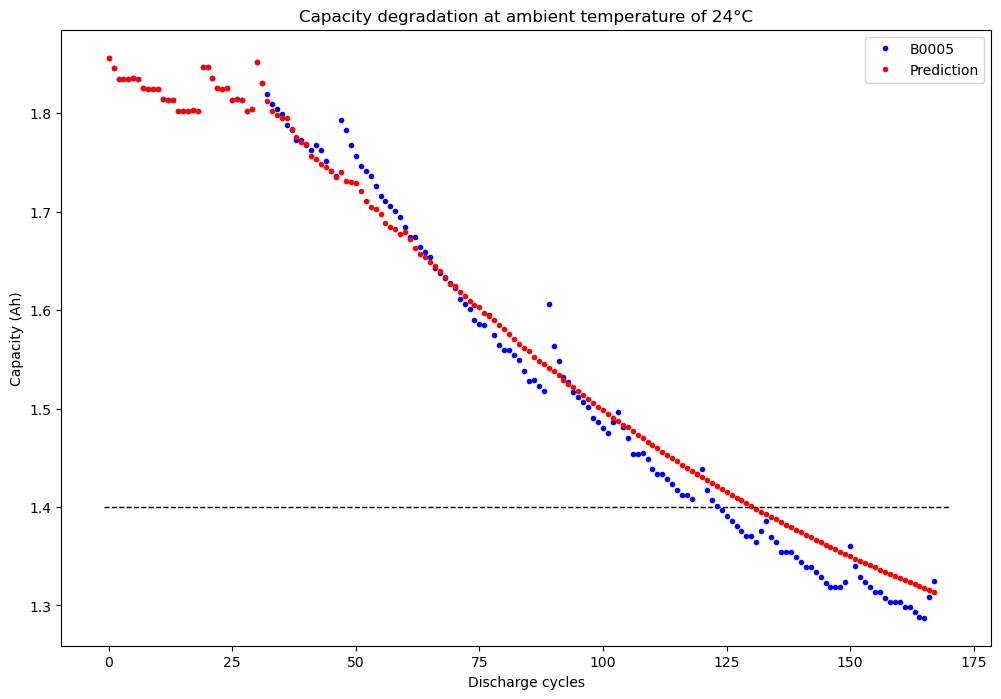

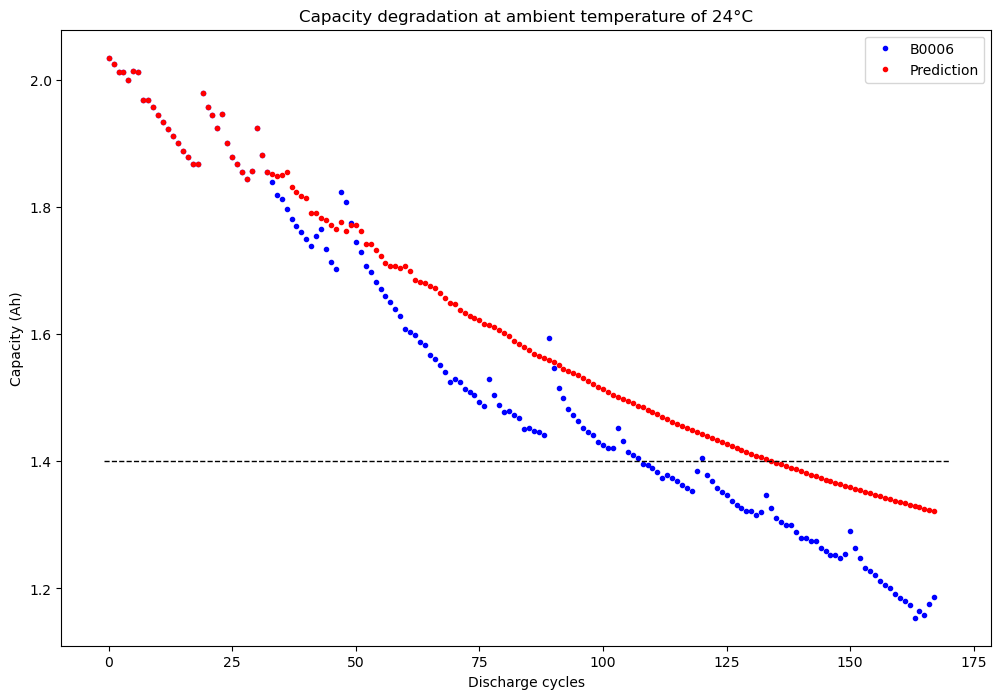

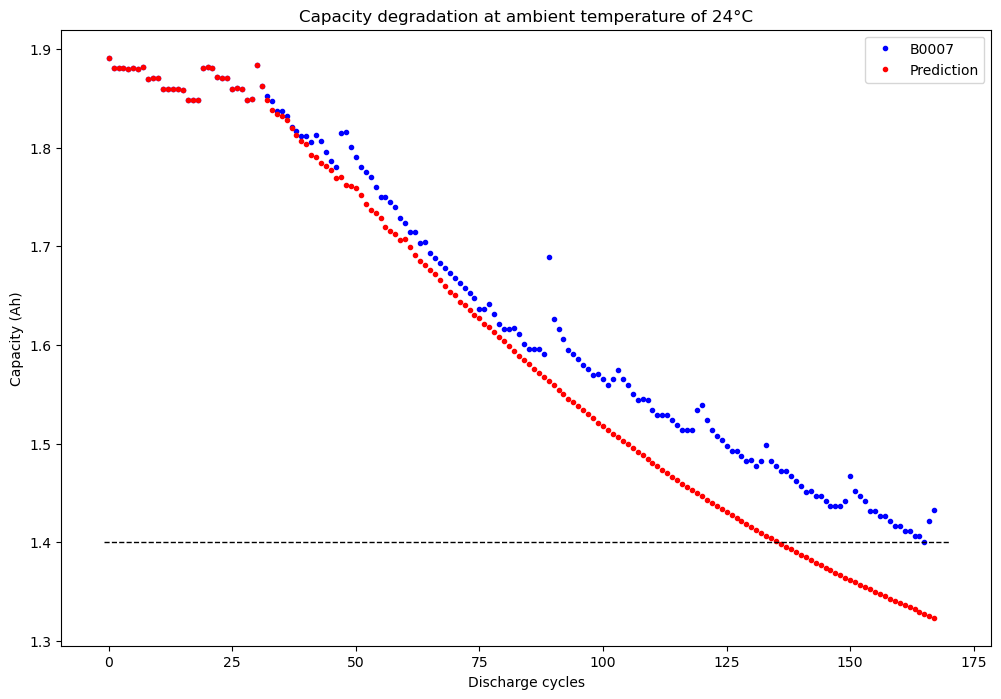

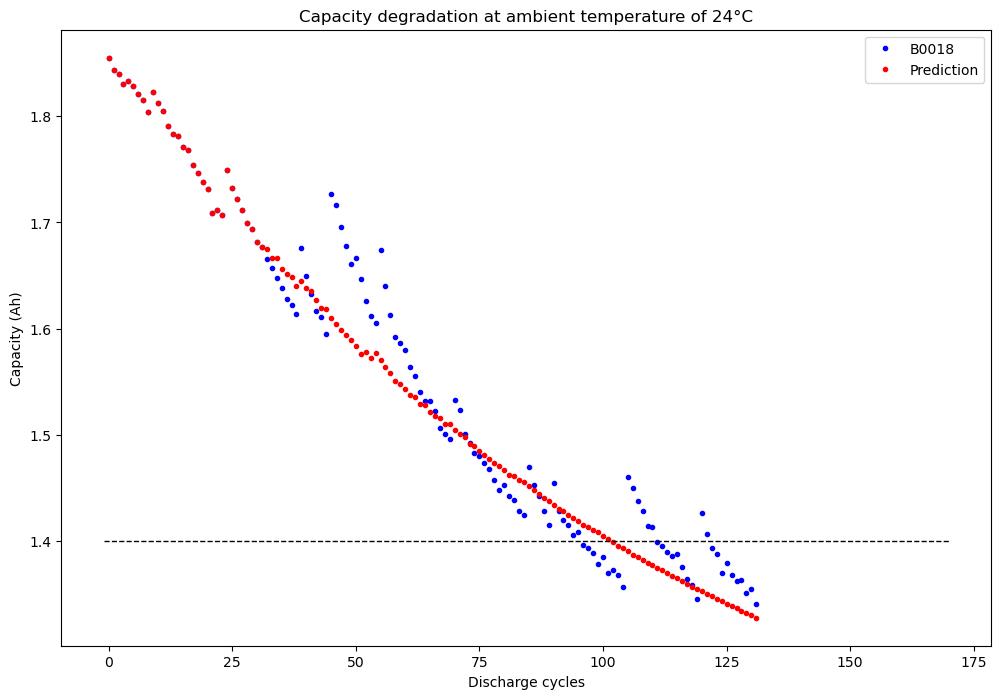

In [24]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)